# Gospel of LSTMs

- This notebook train, evaluate and generate Gospels of Bible. The code is originally forked from [Official Word Level Language Modelling example of PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)  and altered in accordance with the particular use case. 

- The cleaned Gospel data is available at [here](https://github.com/sleebapaul/gospel_of_rnn/tree/master/training_data). 

- Used PyTorch version is  0.4.0. 

- If you're a beginner to RNNs, you may find the comments really helpful. So I commented a lot in this notebook. 

- If you find a difficulty in reproducing the results locally using this Jupyter Notebook, well I would say that's expected. Especially, the data interaction part is needed to be rewritten and it is an additional effort. Because, this notebook is originally a Colab Notebook and architectured in favour of same.  So I recommend the reader to consider this one a local reference and go to [the original Colab notebook](https://colab.research.google.com/drive/1euakjbNiZgCfbmCWzT6pIZB2MYZbHjk-) for a better life!


In [1]:
# Download and setup PyTorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
    
!pip install pydrive

tcmalloc: large alloc 1073750016 bytes == 0x5c996000 @  0x7fb0414791c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 993kB 5.8MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [2]:
import torch

print("PyTorch Version: ",torch.__version__)
print("Cuda availability: ",torch.cuda.is_available())

# for reproducability set the seed 

torch.manual_seed(1111)

PyTorch Version:  0.4.0
Cuda availability:  True


In [0]:
import math
import os
import random
import re
import time

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import torch.nn as nn
from google.colab import files
from torch.nn.utils import clip_grad_norm_

%matplotlib inline 

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Helper functions 

In [0]:
def get_text_files(folder_name):
    """
    Get text files from uploaded files
    """
    text_files = []
    for file in os.listdir("."):
        if file.endswith(".txt"):
            text_files.append(file)
    return sorted(text_files)


def store_files(file_list):
    """
    Read and store files in the file_list as strings 
    Returns a dictionary with keys as file names and values as their contents
    """
    output = {}
    for file in file_list:
        with open(file, 'r') as f:
            output[file] = f.read()
    return output
        

def dictionary(training_data):
    """
    Create word2idx and idx2word dictionaries 
    Returns two dictionaries
    """
    word2idx = {}
    idx2word = {}
    words = training_data.split()
    token = 0
    for word in words: 
        if not word in word2idx:
            word2idx[word] = token
            idx2word[token] = word
            token +=1
    return word2idx, idx2word


def tensor_generator(training_data, word2idx):
    """
    Create a PyTorch LongTensor for the training data
    Returns a 1D tensor with ids of words  
    """
    words = training_data.split()
    ids = torch.LongTensor(len(words))
    
    for i, word in enumerate(words):
        ids[i] = word2idx[word]
        
    return ids

        
def batchify(data, bsz):
    """
    Batch the data with size bsz
    """
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)


def get_batch(source, i):
    """
    Select seq_length long batches at once for training
    Data and Targets will be differed in index by one
    """
    seq_len = min(seq_length, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target


def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.
    For truncated backpropagation 
    """
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


class RNNModel(nn.Module):
    """
    Container module with an encoder, a recurrent module, and a decoder.
    PyTorch provides the facility to write custom models
    """

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)

        self.LSTM = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.LSTM(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())

        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))
    

def evaluate(data_source, eval_batch_size):
    """
    Evaluates the performance of the trained model in input data source
    """
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = vocab_size
    hidden = model.init_hidden(eval_batch_size)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, seq_length):
            data, targets = get_batch(data_source, i)
            output, hidden = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    return total_loss / len(data_source)


def train():
    """
    Training - Full Throttle :D 
    """
    # Turn on training mode which enables dropout.
    
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = vocab_size
    hidden = model.init_hidden(batch_size)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, seq_length)):
        data, targets = get_batch(train_data, i)
        
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        
        hidden = repackage_hidden(hidden)
        model.zero_grad()
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        clip_grad_norm_(model.parameters(), 0.25)
        for p in model.parameters():
            p.data.add_(-learning_rate, p.grad.data)

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:5.4f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f} |'.format(
                epoch, batch, len(train_data) // seq_length, learning_rate,
                elapsed * 1000 /log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
            
            
def get_warmup_state(data_source):
    """
    Starting hidden states as zeros might not deliver the context 
    So a warm up is on a desired primer text 
    Returns the hidden state for actual generation 
    """
    # Turn on evaluation mode which disables dropout.
    model.eval()
    ntokens = vocab_size
    hidden = model.init_hidden(1)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, seq_length):
            data, targets = get_batch(data_source, i)
            hidden = repackage_hidden(hidden)
            output, hidden = model(data, hidden)         
    return hidden


# Data handling 

In [6]:
#Once run this will allow you to manually select the path on local drive for file you wish to upload
!rm *.txt
uploaded = files.upload()
for file in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=file, length=len(uploaded[file])))

rm: cannot remove '*.txt': No such file or directory


Saving john_asv.txt to john_asv.txt
Saving john_bbe.txt to john_bbe.txt
Saving john_dby.txt to john_dby.txt
Saving john_kjv.txt to john_kjv.txt
Saving john_wbt.txt to john_wbt.txt
Saving john_ylt.txt to john_ylt.txt
Saving luke_asv.txt to luke_asv.txt
Saving luke_bbe.txt to luke_bbe.txt
Saving luke_dby.txt to luke_dby.txt
Saving luke_kjv.txt to luke_kjv.txt
Saving luke_wbt.txt to luke_wbt.txt
Saving luke_ylt.txt to luke_ylt.txt
Saving mark_asv.txt to mark_asv.txt
Saving mark_bbe.txt to mark_bbe.txt
Saving mark_dby.txt to mark_dby.txt
Saving mark_kjv.txt to mark_kjv.txt
Saving mark_wbt.txt to mark_wbt.txt
Saving mark_ylt.txt to mark_ylt.txt
Saving matthew_asv.txt to matthew_asv.txt
Saving matthew_bbe.txt to matthew_bbe.txt
Saving matthew_dby.txt to matthew_dby.txt
Saving matthew_kjv.txt to matthew_kjv.txt
Saving matthew_wbt.txt to matthew_wbt.txt
Saving matthew_ylt.txt to matthew_ylt.txt
User uploaded file "john_asv.txt" with length 112922 bytes
User uploaded file "john_bbe.txt" with le

In [7]:
! rm generated_sample.txt

txt_files = get_text_files(".")
print("Files uploaded: ", ", ".join(txt_files))
print("Number of files: ", len(txt_files))

corpora = store_files(txt_files)

rm: cannot remove 'generated_sample.txt': No such file or directory
Files uploaded:  john_asv.txt, john_bbe.txt, john_dby.txt, john_kjv.txt, john_wbt.txt, john_ylt.txt, luke_asv.txt, luke_bbe.txt, luke_dby.txt, luke_kjv.txt, luke_wbt.txt, luke_ylt.txt, mark_asv.txt, mark_bbe.txt, mark_dby.txt, mark_kjv.txt, mark_wbt.txt, mark_ylt.txt, matthew_asv.txt, matthew_bbe.txt, matthew_dby.txt, matthew_kjv.txt, matthew_wbt.txt, matthew_ylt.txt
Number of files:  24


In [8]:
# Copy complete corpora to training
training_files = list(corpora.keys())

# Select a file for validation and remove it from training data
val_file = random.choice(training_files)
training_files.pop(training_files.index(val_file))

# Select a file for test and remove it from training data
test_file = random.choice(training_files)
training_files.pop(training_files.index(test_file))

print("Training files ({}): {}".format(len(training_files), ", ".join(training_files)))
print("Validation file : ", val_file)
print("Testing files : ", test_file)

Training files (22): john_asv.txt, john_bbe.txt, john_dby.txt, john_kjv.txt, john_wbt.txt, john_ylt.txt, luke_asv.txt, luke_bbe.txt, luke_dby.txt, luke_kjv.txt, luke_wbt.txt, luke_ylt.txt, mark_bbe.txt, mark_dby.txt, mark_wbt.txt, mark_ylt.txt, matthew_asv.txt, matthew_bbe.txt, matthew_dby.txt, matthew_kjv.txt, matthew_wbt.txt, matthew_ylt.txt
Validation file :  mark_asv.txt
Testing files :  mark_kjv.txt


In [51]:

# Get the vocabulary by combining all books

combined_corpus = " ".join(list(corpora.values()))

word2idx, idx2word = dictionary(combined_corpus)

print("Total number of words in entire corpus: ", len(combined_corpus.split()))

vocab_size = len(word2idx)

print("Vocabulary size: ", vocab_size)

del combined_corpus

Total number of words in entire corpus:  653611
Vocabulary size:  6067


In [10]:
print("Index of Jesus: ", word2idx["Jesus"])
print("Word of index {}:  {}".format(word2idx["Jesus"], idx2word[word2idx["Jesus"]]))

Index of Jesus:  120
Word of index 120:  Jesus


In [0]:
# Hyper-parameters

embed_size = 300
hidden_size = 1024
num_layers = 2
num_epochs = 100
batch_size = 30
seq_length = 35
learning_rate = 20.0
dropout_value = 0.4
log_interval = 100
eval_batch_size = 10

In [0]:
# Concatenate the training data into a single corpus by selecting corresponding files from corpora
training_data = ""
for file in training_files:
    training_data += corpora[file] + " "
training_data = training_data.rstrip()

In [0]:
# Batchify every data set
train_data = batchify(tensor_generator(training_data, word2idx), batch_size)
val_data = batchify(tensor_generator(corpora[val_file], word2idx), eval_batch_size)
test_data = batchify(tensor_generator(corpora[test_file],word2idx), eval_batch_size)

In [14]:
print("Shape of batchified training data: ", train_data.shape)
print("Shape of batchified validation data: ", val_data.shape)
print("Shape of batchified testing data: ", test_data.shape)

Shape of batchified training data:  torch.Size([20509, 30])
Shape of batchified validation data:  torch.Size([1911, 10])
Shape of batchified testing data:  torch.Size([1919, 10])


# Model definition and training

In [0]:
# Define model for training 

model = RNNModel(ntoken=vocab_size, ninp=embed_size, nhid=hidden_size, nlayers=num_layers, dropout=dropout_value).to(device)
criterion = nn.CrossEntropyLoss()

In [81]:
# Start training the model

best_val_loss = None
training_loss = []
validation_loss = []

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        
        # Start training for one epoch
        train()
        
        # Get and store validation and training losses 
        val_loss = evaluate(val_data, eval_batch_size)
        tr_loss = evaluate(train_data, batch_size)
        
        
        training_loss.append(tr_loss)
        validation_loss.append(val_loss)
        
        print('-' * 122)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                'valid ppl {:8.2f} | training loss {:5.2f} | training ppl {:8.2f} |'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss), tr_loss, math.exp(tr_loss)))
        print('-' * 122)
        
        
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            torch.save(model.state_dict(), "model.pt")
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            learning_rate = learning_rate /1.5
except KeyboardInterrupt:
    print('-' * 122)
    print('Exiting from training early')

| epoch   1 |   100/  562 batches | lr 20.0000 | ms/batch 117.56 | loss  6.61 | ppl   741.10 |
| epoch   1 |   200/  562 batches | lr 20.0000 | ms/batch 113.70 | loss  5.09 | ppl   161.68 |
| epoch   1 |   300/  562 batches | lr 20.0000 | ms/batch 113.86 | loss  4.68 | ppl   107.50 |
| epoch   1 |   400/  562 batches | lr 20.0000 | ms/batch 113.94 | loss  4.37 | ppl    79.19 |
| epoch   1 |   500/  562 batches | lr 20.0000 | ms/batch 113.93 | loss  4.14 | ppl    62.94 |
--------------------------------------------------------------------------------------------------------------------------
| end of epoch   1 | time: 90.22s | valid loss  4.01 | valid ppl    55.36 | training loss  3.97 | training ppl    53.17 |
--------------------------------------------------------------------------------------------------------------------------
| epoch   2 |   100/  562 batches | lr 20.0000 | ms/batch 115.20 | loss  3.96 | ppl    52.25 |
| epoch   2 |   200/  562 batches | lr 20.0000 | ms/batch 114.

# Plotting the performance graph

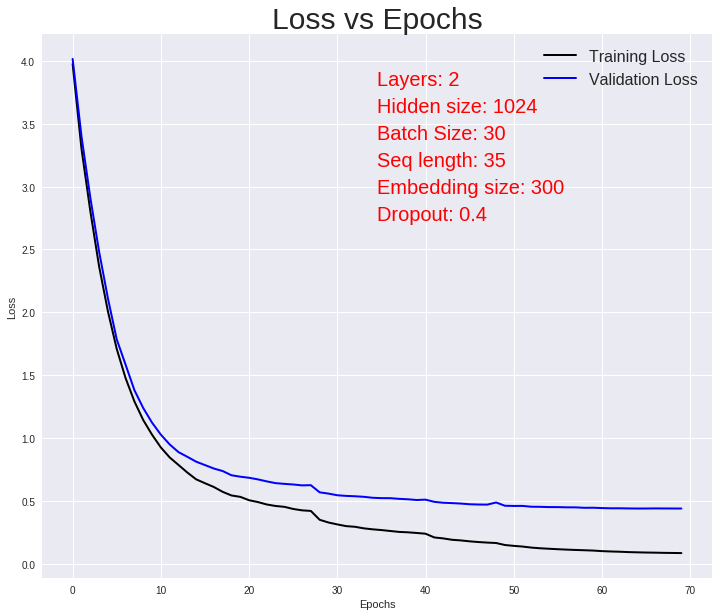

In [82]:
# Let's plot the validation and training loss in different epochs

fig, ax = plt.subplots()
sns.set_style("ticks")
sns.set_context("poster")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs", fontsize=30)


# ax.text(0.5, 0.9, 'Epochs: {}'.format(num_epochs),
#         verticalalignment='bottom', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='Red', fontsize=20)

ax.text(0.5, 0.9, 'Layers: {}'.format(num_layers),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)


ax.text(0.5, 0.85, 'Hidden size: {}'.format(hidden_size),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)


ax.text(0.5, 0.80, 'Batch Size: {}'.format(batch_size),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)

ax.text(0.5, 0.75, 'Seq length: {}'.format(seq_length),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)

# ax.text(0.5, 0.65, 'Learning rate: {:5.4f}'.format(learning_rate),
#         verticalalignment='bottom', horizontalalignment='left',
#         transform=ax.transAxes,
#         color='Red', fontsize=20)

ax.text(0.5, 0.70, 'Embedding size: {}'.format(embed_size),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)

ax.text(0.5, 0.65, 'Dropout: {}'.format(dropout_value),
        verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,
        color='Red', fontsize=20)


plt.plot( training_loss, color='black', linewidth = 2, label='Training Loss')
plt.plot( validation_loss, color='blue', linewidth = 2, label='Validation Loss')
plt.legend(loc='best')
fig.set_size_inches(12, 10)
plt.savefig("loss_iter_graph.png", dpi=600)
plt.show()


In [0]:
files.download('loss_iter_graph.png')

# files.download('model.pt')

# Upload the trained model to Google Drive 

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [88]:
uploaded = drive.CreateFile({'trainedmodel': 'model.pt'})
uploaded.SetContentFile('model.pt')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1HRK6l6WPjba3tmhdDsv752pfOB2aQ9T2


# Evaluation and Sampling


In [16]:
# files.download('model.pt')
# You can download the model directly from Colab using the above command. But sometimes, Colab behaves weird and corrupt your file while downloading. So I chose to upload it to Google Drive 
# first, then download it to a local machine. 

# This trained model is downloaded hosted in my GitHub repo. I you're training your own, then you may need to host it up somewhere else and get it for testing. 
# You can directly upload the model to Colab, but trust me, uploading is boring in Colab. 

!wget https://github.com/sleebapaul/gospel_of_rnn/raw/master/best_model/model.pt


Redirecting output to ‘wget-log.1’.


In [0]:
# Define model and load the states
# Remember, it won't work if you've changed the hyperparameters

model = RNNModel(ntoken=vocab_size, ninp=embed_size, nhid=hidden_size, nlayers=num_layers, dropout=dropout_value).to(device)
model.load_state_dict(torch.load("model.pt"))

criterion = nn.CrossEntropyLoss()

In [35]:
# Run on test data.
test_data = batchify(tensor_generator(corpora["matthew_ylt.txt"],word2idx), eval_batch_size)
test_loss = evaluate(test_data, eval_batch_size)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  0.11 | test ppl     1.11


### If you would like to generate a number of words and save it to a file, you may use the below code.

In [48]:
num_samples = 25000   # Number of words to be generated 
temperature = 0.8     # Adjust temperature from 0.0 to 1.0 for diversity

chapter = 1
verses = 1
model.eval()         

# No warmup 
hidden = model.init_hidden(1)

# initial_input = torch.LongTensor([[word2idx["<SOC>"]]])
initial_input = torch.randint(vocab_size, (1, 1), dtype=torch.long).to(device)
input = initial_input.to(device)

with open('generated_sample.txt', 'w') as outf:
    
    outf.write("\n\n")
    with torch.no_grad():  # no tracking history
        for i in range(num_samples):
            
            output, hidden = model(input, hidden)
            word_weights = output.squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]

            word = idx2word[word_idx.item()]
            
            # Maximum verses in limited to 60 by EDA
            if verses >= 60 and word != "<EOC>":
                word_idx = torch.tensor(word2idx["<SOC>"])
                word = idx2word[word_idx.item()]


            if word == "<EOC>":
                word = "\n\n"
                
            elif word == "<SOC>":
                word = "\n\n" + str(chapter) + "\n\n"
                chapter += 1
                verses = 1

            elif word == "<SOV>":
                word = "\n" + str(verses) + " "
                verses += 1
            elif word == "<EOV>":
                word = "\n"
            else:
                word =  word + ' '

            outf.write(word)
            if (i+1) % 1000 == 0:
                print('|Sampled [{}/{}] words and save to {}|'.format(i+1, num_samples, 'sample.txt'))   
            
            input.fill_(word_idx)
            
            if chapter>28:
                break

|Sampled [1000/25000] words and save to sample.txt|
|Sampled [2000/25000] words and save to sample.txt|
|Sampled [3000/25000] words and save to sample.txt|
|Sampled [4000/25000] words and save to sample.txt|
|Sampled [5000/25000] words and save to sample.txt|
|Sampled [6000/25000] words and save to sample.txt|
|Sampled [7000/25000] words and save to sample.txt|
|Sampled [8000/25000] words and save to sample.txt|
|Sampled [9000/25000] words and save to sample.txt|
|Sampled [10000/25000] words and save to sample.txt|
|Sampled [11000/25000] words and save to sample.txt|
|Sampled [12000/25000] words and save to sample.txt|
|Sampled [13000/25000] words and save to sample.txt|
|Sampled [14000/25000] words and save to sample.txt|
|Sampled [15000/25000] words and save to sample.txt|
|Sampled [16000/25000] words and save to sample.txt|
|Sampled [17000/25000] words and save to sample.txt|
|Sampled [18000/25000] words and save to sample.txt|
|Sampled [19000/25000] words and save to sample.txt|
|S

In [0]:
files.download('generated_sample.txt')

#### If you would like to generate with a warmup primer text, use the below function. 

In [0]:
def generate_chapter(model, context, temperature=0.5):
    """
    Generate a chapter with given context and model
    """
    
    model.eval()
    
    word = "<SOC>"    # Starting token
    
    initial_input = torch.LongTensor([[word2idx[word]]])
    input = initial_input.to(device)
    
    generated_text = "\n1 "
    verses = 2
    
    with torch.no_grad():  # no tracking history
        
        while word != "<EOC>": 
            output, context = model(input, context)
            word_weights = output.squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]

            word = idx2word[word_idx.item()]
            
            if verses > 59 and word != "<EOC>":
                break
                
            if word == "<SOC>":
                word = "\n\n"
                break

            if word == "<SOV>":
                word = "\n" + str(verses) + " "
                verses += 1
            elif word == "<EOV>":
                word = ""
            else:
                word =  word + ' '

            generated_text += word
            word = idx2word[word_idx.item()]
            input.fill_(word_idx)
    
    generated_text = generated_text.strip()
    generated_text = generated_text.rstrip("<EOC>")
    generated_text = generated_text.rstrip("59")
    
    generated_text = generated_text.strip()
    return generated_text

In [27]:
# Generate the Gospel of LSTM with your context

gospel_of_lstms = "1\n\n"
context = re.split(" <SOC>", corpora["mark_asv.txt"])
for i, text in enumerate(context):
    if not text.startswith("<SOC>"):
        text = "<SOC> " + text
    text = text.strip()
    text = batchify(tensor_generator(text, word2idx), 1)
    warmup_state = get_warmup_state(text)
#     warmup_state = model.init_hidden(1)
    
    output = generate_chapter(model, warmup_state, temperature= 0.5)
    gospel_of_lstms += output + "\n\n" + str(i+2) + "\n\n"
    
    print("{}th chapter is generated".format(i+1))

gospel_of_lstms = gospel_of_lstms.strip()

1th chapter is generated
2th chapter is generated
3th chapter is generated
4th chapter is generated
5th chapter is generated
6th chapter is generated
7th chapter is generated
8th chapter is generated
9th chapter is generated
10th chapter is generated
11th chapter is generated
12th chapter is generated
13th chapter is generated
14th chapter is generated
15th chapter is generated
16th chapter is generated


In [0]:
with open("gospel_of_lstms.txt", "w") as text_file:
    text_file.write(gospel_of_lstms)

In [0]:
files.download('gospel_of_lstms.txt')